In [1]:
import jax.numpy as jnp
import numpy as np

import jax
from jax import nn as jnn
from jax import random

from flax import linen as nn
from flax import optim

import optax

import h5py
from fenics import *

from typing import Sequence

import matplotlib.pyplot as plt

import basix
from basix import ElementFamily, CellType, LagrangeVariant

from scipy.optimize import least_squares, fsolve

# again, this only works on startup!
from jax.config import config
config.update("jax_enable_x64", True)

2022-03-19 00:02:08.044004: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-19 00:02:08.178753: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-19 00:02:08.190343: W external/org_tensorflow/tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
hwloc/linux: Ignoring PCI device with non-16bit domain.
Pass --enable-32bits-pci-domain to configure to support such devices
(warning: it would break the library ABI, don't enable unless really needed).


In [2]:
def read_mesh_and_function(file_name, var_name):

    # Open solution file
    infile = XDMFFile(file_name + ".xdmf")
    infile_h5 = h5py.File(file_name + ".h5", "r")
    t_steps = len(infile_h5[var_name].keys())

    # Read in mesh
    mesh = Mesh()
    infile.read(mesh)

    # Read function
    V = FunctionSpace(mesh, "CG", 1)
    u = Function(V)
    solution = np.zeros((V.dim(), t_steps))
    for i in range(t_steps):
        infile.read_checkpoint(u, var_name, i - t_steps + 1)
        solution[:, i] = u.vector().get_local()

    # Clean up
    infile.close()
    infile_h5.close()

    return mesh, solution
    
nu = 0.001
A = 0.5
mesh, u_ref = read_mesh_and_function("output/burgers_1D/nu_"+str(nu)+"/FOM", "u")
u_ref = u_ref.T

In [3]:
time_steps, N = u_ref.shape
u_train = u_ref[np.arange(0,time_steps,10)]
n = 100
M1 = 100
n_epoch = 20000

In [4]:
class Encoder(nn.Module):
    latents: Sequence[int]
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.latents[0],dtype=jnp.float64,param_dtype=jnp.float64)(x)
        x = nn.swish(x)
        xr = nn.Dense(self.latents[1],dtype=jnp.float64,param_dtype=jnp.float64)(x)
        return xr

In [5]:
def gaussian_kernel(window_size, sigma):
    mu = window_size / 2
    x = jnp.arange(window_size)
    window = jnp.exp((-((x-mu)**2))/(2*sigma**2))/sigma/jnp.sqrt(2*jnp.pi)
    return window

class Decoder(nn.Module):
    @nn.compact
    def __call__(self, x):
        x_net = jnp.zeros((N,))
        sigma0s = jnp.arange(1, n+1) * (N / 6 / n)
        sigmas = self.param('sigma', lambda key : sigma0s)
        sub_weights = nn.Dense(n,dtype=jnp.float64,param_dtype=jnp.float64)(x)
    
        for i in range(n):
            xi = nn.Dense(N,dtype=jnp.float64,param_dtype=jnp.float64)([x[i]])
            window = gaussian_kernel(N, sigmas[i])
            xi = jnp.convolve(xi, window, mode='same')
            x_net = x_net + sub_weights[i] * xi
        
        return x_net

In [6]:
class VAE(nn.Module):
    encoder_latents: Sequence[int]

    def setup(self):
        self.encoder = Encoder(self.encoder_latents)
        self.decoder = Decoder()
    
    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)

    def __call__(self, x):
        return self.decode(self.encode(x))

def model():
    return VAE(encoder_latents=[M1,n])

In [7]:
@jax.jit
def loss_fn(params, x):
    xt = jax.vmap(model().apply, in_axes=(None, 0))(params, x)
    errors = jax.vmap(rel_err, in_axes=(0,0), out_axes=0)(x,xt)
    l = jnp.sum(errors**2)/time_steps
    return l

def rel_err(x, xt):
    return jnp.linalg.norm(x-xt)

params = model().init(random.PRNGKey(0), u_train[0])
tx = optax.adam(0.001)
opt_state = tx.init(params)
loss_grad_fn = jax.jit(jax.value_and_grad(loss_fn))
min_loss = 100
best_params = params

2022-03-19 00:02:11.264907: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


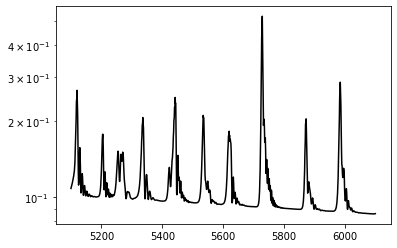

Loss step 6110:  0.1248255392026862


KeyboardInterrupt: 

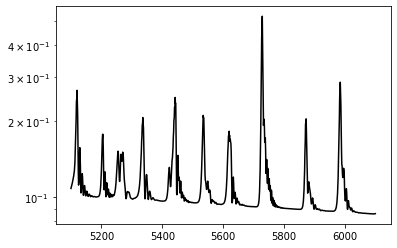

In [8]:
from IPython import display
loss_history = np.zeros((n_epoch)) * np.nan

for i in range(n_epoch):
    loss_val, grads = loss_grad_fn(params, u_train)
    loss_history[i] = loss_val
    if loss_val < min_loss:
        min_loss = loss_val
        best_params = params
    updates, opt_state = tx.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    if i % 10 == 0:
        print('Loss step {}: '.format(i), loss_val)
    if i % 100 == 0:
        last_epochs = np.arange(np.max([i-1000,0]), i, dtype=int)
        plt.clf()
        plt.semilogy(last_epochs, loss_history[last_epochs], 'k')
        display.clear_output(wait=True)
        display.display(plt.gcf())
    if loss_val < 1e-3:
        break
params = best_params

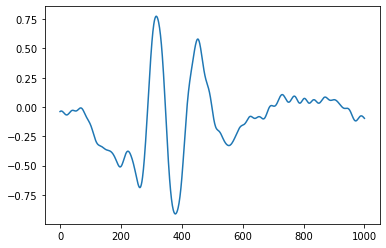

In [9]:
u_ref_encoded = model().apply(params, u_ref[200], method=VAE.encode)
Phi = jax.jacobian(model().apply, argnums=1)(params, u_ref_encoded, method=VAE.decode)
plt.plot(Phi.T[0])

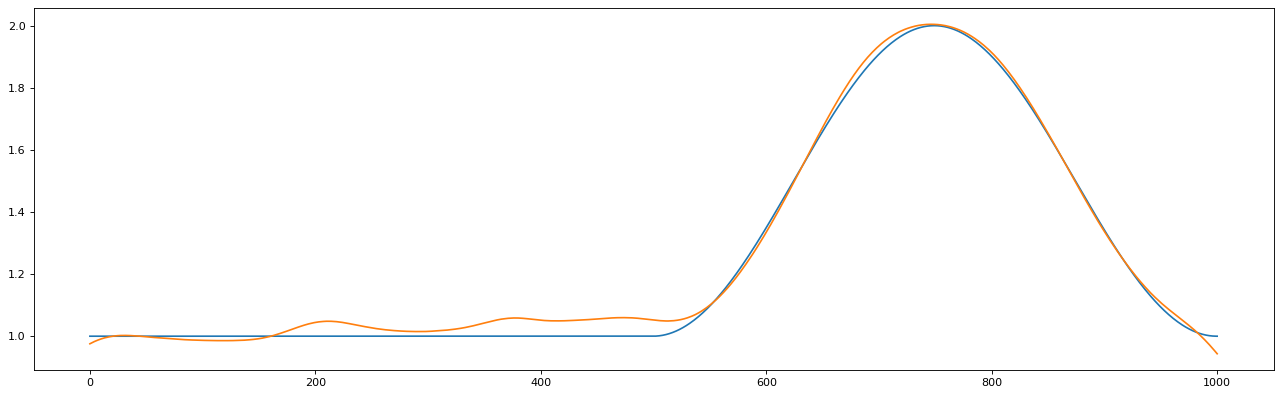

In [10]:
plt.figure(figsize=(20, 6), dpi=80)
plt.plot(u_ref[0])
plt.plot(model().apply(params, u_ref[0]))

In [ ]:
t_start = 0.0
t_final = 0.5
t_steps = 500
t_sequence = np.linspace(t_start, t_final, t_steps + 1)
dt = (t_final - t_start) / t_steps

V = FunctionSpace(mesh, "CG", 1)

In [ ]:
nelem = mesh.num_cells()

# Per element
nqp = 2
ndof = 2
nvertex = 2
nnode = 2
ndim = 2

# Data structure to be computed per element
dof_map = np.zeros((nelem,ndof), dtype=int)
JxW = np.zeros((nelem,nqp))
grad_test = np.zeros((nelem,nqp,nnode,ndim))

lagrange = basix.create_element(ElementFamily.P, CellType.interval, 1, LagrangeVariant.equispaced)
ref_points, weights = basix.make_quadrature(CellType.interval, 2)
test, ref_grad_test = lagrange.tabulate(1, ref_points)
test = test.reshape(2,2)
ref_grad_test = ref_grad_test.reshape(2,2)

for e in range(nelem):
    cell = Cell(mesh, e)
    dof_map[e] = V.dofmap().cell_dofs(e)
    coordinates = np.array(cell.get_coordinate_dofs()).reshape(2,2)
    for qp,weight in enumerate(weights):
        J = jnp.matmul(ref_grad_test[qp], coordinates)
        detJ = jnp.sqrt(jnp.dot(J, J))
        JxW[e][qp] = detJ*weight
        grad_test[e][qp] = jnp.vstack((ref_grad_test[qp]/detJ, jnp.zeros((1,2)))).T

dof_map = jnp.array(dof_map)
JxW = jnp.array(JxW)
grad_test = jnp.array(grad_test)

In [ ]:
def local_residual(dofs,JxW,test,grad_test,ut,ut_old):
    local_re = jnp.zeros((N,))
    for i in range(nnode):
        r = 0
        for qp in range(nqp):
            u = jnp.dot(test[qp], ut[dofs])
            u_old = jnp.dot(test[qp], ut_old[dofs])
            grad_u = jnp.matmul(ut[dofs], grad_test[qp])
            r = r + (test[qp][i]*(u-u_old)/dt+nu*jnp.dot(grad_test[qp][i],grad_u)+test[qp][i]*grad_u[0]*u) * JxW[qp]
        local_re = local_re.at[dofs[i]].set(r)
    return local_re

In [ ]:
def objective(ur, ur_old, params):
    ut = model().apply(params, ur, method=VAE.decode)
    ut_old = model().apply(params, ur_old, method=VAE.decode)
    local_res = jax.vmap(local_residual, in_axes=(0,0,None,0,None,None), out_axes=0)(dof_map,JxW,test,grad_test,ut,ut_old)
    r = jnp.sum(local_res,axis=0)
    return 0.5*jnp.dot(r,r)

residual = jax.jit(jax.grad(objective))

# def residual(ur, ur_old, params):
#     ut = model().apply(params, ur, method=VAE.decode)
#     ut_old = model().apply(params, ur_old, method=VAE.decode)
#     local_res = jax.vmap(local_residual, in_axes=(0,0,None,0,None,None), out_axes=0)(dof_map,JxW,test,grad_test,ut,ut_old)
#     r = jnp.sum(local_res,axis=0)
#     return r

jacobian = jax.jit(jax.jacfwd(jax.grad(objective)))

In [ ]:
def solve(u, u_old, nl_max_its=10, RTOL=1e-6, ATOL=1e-8):
    def converged(r, r0):
        if jnp.linalg.norm(r) < ATOL:
            return True
        if jnp.linalg.norm(r) < RTOL * jnp.linalg.norm(r0):
            return True
        return False

    r = residual(u, u_old, params)
    r0 = r
    for itr in range(nl_max_its):
        print('Itr = {:}, |R| = {:.3E}'.format(itr, jnp.linalg.norm(r)))

        if converged(r, r0):
            return u
        
        J = jacobian(u, u_old, params)

        du = - jnp.linalg.solve(J, r)
        u = u + du
        r = residual(u, u_old, params)

    return u

In [ ]:
u_approx = np.zeros((t_steps+1,N))

u0 = Function(V)
u0_expr = Expression(
    "x[0] < 1 ? 1+A*(sin(2*pi*x[0]-pi/2)+1) : 1", degree=1, A=A)
u0.interpolate(u0_expr)

ur0 = model().apply(params, u0.vector().get_local(), method=VAE.encode)
ur = ur0

def residual_helper(ur, ur_old, params):
    return np.array(residual(ur, ur_old, params))

def jacobian_helper(ur, ur_old, params):
    return np.array(jacobian(ur, ur_old, params))

from IPython.display import clear_output

for i, t in enumerate(t_sequence):
    if i % 2 == 0:
        clear_output(wait=True)
    print('\nstep = {}, t = {}'.format(i, t))
    ur_old = np.array(ur)
    ur = solve(ur, ur_old, nl_max_its=10)
    # res = least_squares(residual_helper, ur, jac=jacobian_helper, loss='soft_l1', tr_solver='exact', args=(ur_old, params), verbose=2)
    # ur = res.x
    # ur,_,_,mesg = fsolve(residual_helper, ur, fprime=jacobian_helper, args=(ur_old, params), full_output=True)
    # print('|R| = {:}, {:}'.format(jnp.linalg.norm(residual(ur, ur_old, params)), mesg))
    u_approx[i] = model().apply(params, ur, method=VAE.decode)

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(u_approx.T, aspect='auto', cmap='jet', vmin=1, vmax=2)
cb = fig.colorbar(im)

In [ ]:
fig, ax = plt.subplots()
im = ax.imshow(u_ref.T, aspect='auto', cmap='jet', vmin=1, vmax=2)
cb = fig.colorbar(im)